In [ ]:
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

(720, 2)
(200, 2)
(80, 2)


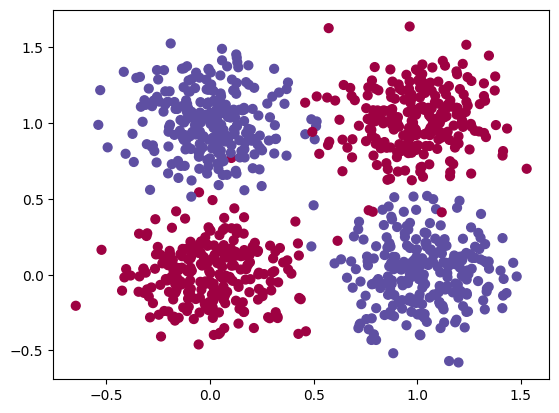

In [ ]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

my_model = keras.Sequential()
def create_xor_model():
    model = keras.Sequential([
        keras.layers.Dense(units=8, activation='relu', input_shape=(2,)),
        keras.layers.Dense(units=4, activation='relu'),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    model = create_xor_model()
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print("\nModel Performance:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return model, history, test_accuracy

model, history, standard_test_acc = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/100
23/23 [==============================] - 1s 9ms/step - loss: 0.6522 - accuracy: 0.6347 - val_loss: 0.5809 - val_accuracy: 0.8125
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.8639 - val_loss: 0.4520 - val_accuracy: 0.9000
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.9222 - val_loss: 0.3124 - val_accuracy: 0.9250
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.9500 - val_loss: 0.2307 - val_accuracy: 0.9625
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9667 - val_loss: 0.1795 - val_accuracy: 0.9750
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.9764 - val_loss: 0.1586 - val_accuracy: 0.9500
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9847 - val_loss: 0.1464 - val_accuracy: 0.9500
Epoch 8/100
2

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):
    def __init__ (self, n0, n1, n2, alpha=0.01):
        np.random.seed(42)
        self.W1 = np.random.randn(n1, n0) * np.sqrt(2.0 / n0)
        self.b1 = np.zeros((n1, 1))
        self.W2 = np.random.randn(n2, n1) * np.sqrt(2.0 / n1)
        self.b2 = np.zeros((n2, 1))
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse_output=False)

    def forward_pass(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2  # Linear transformation
        exp_scores = np.exp(Z2 - np.max(Z2, axis=0, keepdims=True))  # Subtract max for numerical stability
        A2 = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
        return A1, A2

    def loss(self, X, y):
        m = y.shape[0]
        A1, A2 = self.forward_pass(X)
        Y = self.one_hot(y)
        epsilon = 1e-15
        L = -np.sum(Y * np.log(A2 + epsilon)) / m

        return L

    def backward_pass(self, A1, A2, X, y):
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y)
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):
            A1, A2 = self.forward_pass(X)
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)
            self.W1 -= self.alpha * dW1
            self.b1 -= self.alpha * db1
            self.W2 -= self.alpha * dW2
            self.b2 -= self.alpha * db2

            # print loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        if (X.shape[0] > X.shape[1]): X = X.T
        _, A2 = self.forward_pass(X)
        y_hat = np.argmax(A2, axis=0)

        return y_hat


    def evaluate(self, X, y):
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T


    def plot_decision_boundary(self, X, y):
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (30 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

Training Model 1 - Balanced Architecture
Epoch 0/300 - loss: 0.660638 - accuracy: 0.511111 - val_loss: 0.681008 - val_accuracy: 0.425000
Epoch 10/300 - loss: 0.615677 - accuracy: 0.638889 - val_loss: 0.629033 - val_accuracy: 0.612500
Epoch 20/300 - loss: 0.578530 - accuracy: 0.758333 - val_loss: 0.589128 - val_accuracy: 0.800000
Epoch 30/300 - loss: 0.538077 - accuracy: 0.825000 - val_loss: 0.547386 - val_accuracy: 0.837500
Epoch 40/300 - loss: 0.492642 - accuracy: 0.895833 - val_loss: 0.500767 - val_accuracy: 0.900000
Epoch 50/300 - loss: 0.442060 - accuracy: 0.951389 - val_loss: 0.449082 - val_accuracy: 0.962500
Epoch 60/300 - loss: 0.388418 - accuracy: 0.983333 - val_loss: 0.394827 - val_accuracy: 0.975000
Epoch 70/300 - loss: 0.336035 - accuracy: 0.988889 - val_loss: 0.342589 - val_accuracy: 0.987500
Epoch 80/300 - loss: 0.289089 - accuracy: 0.986111 - val_loss: 0.296366 - val_accuracy: 0.975000
Epoch 90/300 - loss: 0.249621 - accuracy: 0.986111 - val_loss: 0.257821 - val_accuracy:

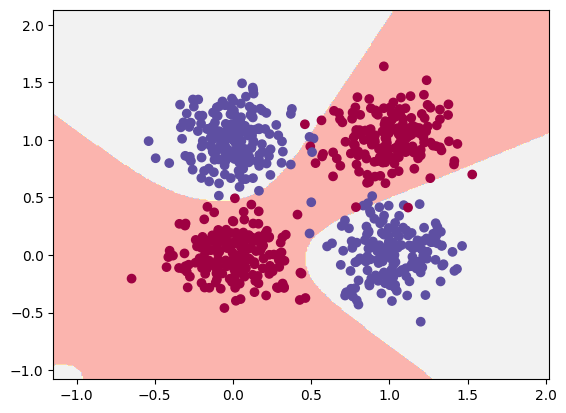

In [ ]:
n0 = 2
n1 = 6
n2 = 2
alpha = 0.3
epochs = 300


print("Training Model 1 - Balanced Architecture")
myModel1 = MyNeuralNet(2, 6, 2, 0.3)
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
test_acc1 = myModel1.evaluate(X_test, y_test)
print("Accuracy on the test set is ", test_acc1)

myModel1.plot_decision_boundary(X_train, y_train)



Training Model 2 - Deeper Architecture
Epoch 0/300 - loss: 0.752294 - accuracy: 0.554167 - val_loss: 0.736424 - val_accuracy: 0.587500
Epoch 10/300 - loss: 0.599576 - accuracy: 0.890278 - val_loss: 0.580506 - val_accuracy: 0.937500
Epoch 20/300 - loss: 0.526859 - accuracy: 0.952778 - val_loss: 0.522092 - val_accuracy: 0.950000
Epoch 30/300 - loss: 0.466457 - accuracy: 0.963889 - val_loss: 0.467191 - val_accuracy: 0.937500
Epoch 40/300 - loss: 0.413314 - accuracy: 0.973611 - val_loss: 0.416259 - val_accuracy: 0.950000
Epoch 50/300 - loss: 0.366396 - accuracy: 0.976389 - val_loss: 0.370544 - val_accuracy: 0.950000
Epoch 60/300 - loss: 0.325383 - accuracy: 0.979167 - val_loss: 0.330518 - val_accuracy: 0.950000
Epoch 70/300 - loss: 0.289983 - accuracy: 0.980556 - val_loss: 0.296088 - val_accuracy: 0.950000
Epoch 80/300 - loss: 0.259757 - accuracy: 0.981944 - val_loss: 0.266818 - val_accuracy: 0.950000
Epoch 90/300 - loss: 0.234127 - accuracy: 0.981944 - val_loss: 0.242093 - val_accuracy: 

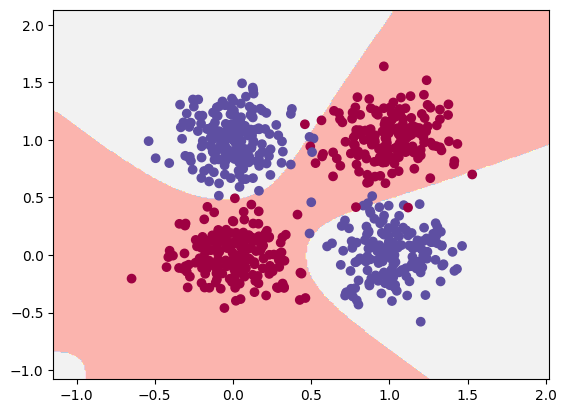

In [ ]:
n0 = 2
n1 = 12
n2 = 2
alpha = 0.2
epochs = 300

print("\nTraining Model 2 - Deeper Architecture")
myModel2 = MyNeuralNet(n0, n1, n2, alpha)
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
test_acc2 = myModel2.evaluate(X_test, y_test)
print("Accuracy on the test set is ", test_acc2)

myModel2.plot_decision_boundary(X_train, y_train)


Training Model 3 - Large Architecture
Epoch 0/300 - loss: 0.746571 - accuracy: 0.490278 - val_loss: 0.742819 - val_accuracy: 0.512500
Epoch 10/300 - loss: 0.647849 - accuracy: 0.806944 - val_loss: 0.639818 - val_accuracy: 0.850000
Epoch 20/300 - loss: 0.579420 - accuracy: 0.934722 - val_loss: 0.573933 - val_accuracy: 0.925000
Epoch 30/300 - loss: 0.518125 - accuracy: 0.954167 - val_loss: 0.513156 - val_accuracy: 0.937500
Epoch 40/300 - loss: 0.462558 - accuracy: 0.969444 - val_loss: 0.458141 - val_accuracy: 0.950000
Epoch 50/300 - loss: 0.412570 - accuracy: 0.972222 - val_loss: 0.408998 - val_accuracy: 0.950000
Epoch 60/300 - loss: 0.368263 - accuracy: 0.973611 - val_loss: 0.365810 - val_accuracy: 0.950000
Epoch 70/300 - loss: 0.329578 - accuracy: 0.977778 - val_loss: 0.328441 - val_accuracy: 0.950000
Epoch 80/300 - loss: 0.296195 - accuracy: 0.981944 - val_loss: 0.296481 - val_accuracy: 0.950000
Epoch 90/300 - loss: 0.267601 - accuracy: 0.980556 - val_loss: 0.269330 - val_accuracy: 0

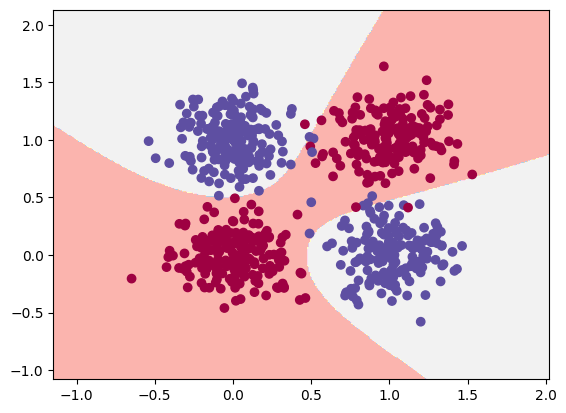

In [ ]:
n0 = 2
n1 = 20
n2 = 2
alpha = 0.15
epochs = 300

print("\nTraining Model 3 - Large Architecture")
myModel3 = MyNeuralNet(n0, n1, n2, alpha)
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
test_acc3 = myModel3.evaluate(X_test, y_test)
print("Accuracy on the test set is ", test_acc3)

myModel3.plot_decision_boundary(X_train, y_train)

In [ ]:
https://www.youtube.com/watch?v=PNr51ZJkoBUtest_loss, standard_test_acc = model.evaluate(X_test, y_test, verbose=0)

print("\nModel Comparison Summary:")
print("-" * 50)
print(f"Standard Library Model Test Accuracy: {standard_test_acc:.4f}")
print(f"Custom Model 1 (6 hidden units) Test Accuracy: {test_acc1:.4f}")
print(f"Custom Model 2 (12 hidden units) Test Accuracy: {test_acc2:.4f}")
print(f"Custom Model 3 (20 hidden units) Test Accuracy: {test_acc3:.4f}")


Model Comparison Summary:
--------------------------------------------------
Standard Library Model Test Accuracy: 0.9700
Custom Model 1 (6 hidden units) Test Accuracy: 0.9650
Custom Model 2 (12 hidden units) Test Accuracy: 0.9650
Custom Model 3 (20 hidden units) Test Accuracy: 0.9600
